## Imports

In [1]:
# Imports/

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

## Get filenames

In [2]:
# Get files in data path
path='TestSound/'
# Get Audio Files
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 95 audio files in TestSound/


## Prepare labels from filenames

In [3]:
labels =[]
classes=['Test']



color_dict={'Test':'blue'}

color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [4]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

1 classes: Test


## Parameters for MFCC

In [5]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Function to Calculate Audio Features: MFCC

In [6]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

## Load audio files, calculate features and create feature vectors

In [7]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 95 = TestSound/XC14381 - American Coot - Fulica americana~1.wav
get 2 of 95 = TestSound/XC715 - Ruddy Pigeon - Patagioenas subvinacea.wav
get 3 of 95 = TestSound/XC14345 - Purple-crowned Plovercrest - Stephanoxis loddigesii.wav
get 4 of 95 = TestSound/XC179459 - Ridgway's Rail - Rallus obsoletus.wav
get 5 of 95 = TestSound/XC51141 - White-tufted Grebe - Rollandia rolland.wav
get 6 of 95 = TestSound/XC45353 - Spot-flanked Gallinule - Porphyriops melanops crassirostris.wav
get 7 of 95 = TestSound/XC15483 - Rufous-faced Crake - Laterallus xenopterus.wav
get 8 of 95 = TestSound/XC2479 - Andean Avocet - Recurvirostra andina.wav
get 9 of 95 = TestSound/XC43622 - Yellow-billed Turaco - Tauraco macrorhynchus.wav
get 10 of 95 = TestSound/XC22547 - Masked Lapwing - Vanellus miles.wav
get 11 of 95 = TestSound/XC114691 - Kalij Pheasant - Lophura leucomelanos hamiltonii.wav
get 12 of 95 = TestSound/XC93965 - Black-winged Stilt - Himantopus himantopus (1).wav
get 13 of 95 = TestSound/XC7799

## Standardization: Zero-Mean and Unit-Variance

In [8]:
# Scale features using Standard Scaler
scaler = StandardScaler()
testing_set = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",testing_set.shape)

Feature vectors shape: (95, 13)


In [9]:
# Check Set Shapes
print("testing_set shape:",testing_set.shape)
print("testing_classes shape:",classes_num.shape)

testing_set shape: (95, 13)
testing_classes shape: (95,)


## t-SNE

In [10]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [11]:
#labels = np.array(classes_num)
labels_ids = np.array(classes_num)
labels = np.array(labels)
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [12]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()


In [13]:
def visualize_scatter(data_2d, label_ids, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

In [14]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(testing_set)
X_embedded.shape

(95, 2)

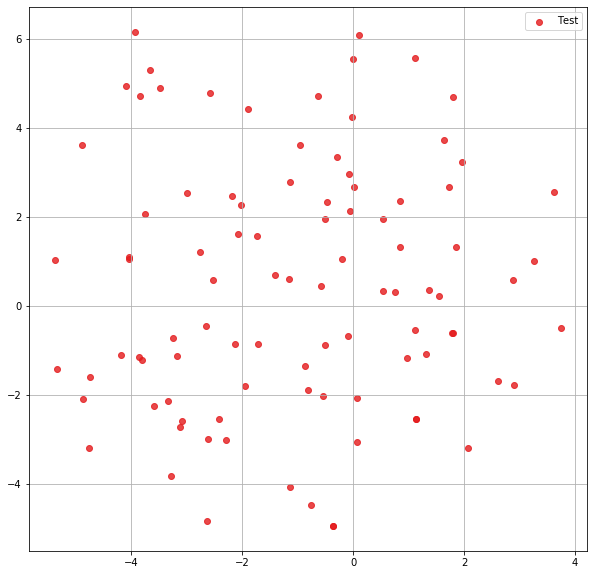

In [15]:
visualize_scatter(X_embedded,label_ids)

## K-Means Algorithim

In [30]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=7, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(testing_set)

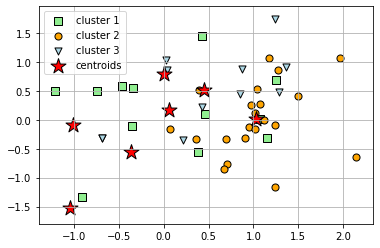

In [31]:
# plot the 3 clusters
plt.scatter(
    testing_set[y_km == 0, 0], testing_set[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    testing_set[y_km == 1, 0], testing_set[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    testing_set[y_km == 2, 0], testing_set[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

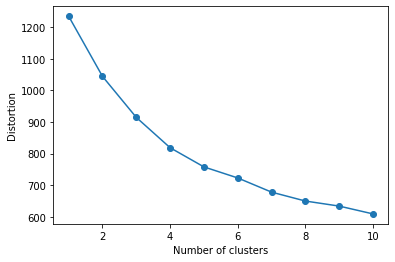

In [33]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(testing_set)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [18]:
import sklearn

In [19]:
model_kmeans = sklearn.cluster.KMeans(n_clusters=20)

In [20]:
model_kmeans.fit(testing_set, classes_num);

In [21]:
# Predict using the Test Set
predicted_labels = model_kmeans.predict(testing_set)
print(predicted_labels)

[15  0 14  3  2  1  4 15  1  8  3  3  1  2 19 18  5  6  3 10  1  2  1 12
  1  5  1  1  8  8  3  8 10  1  0  1 17 11 15  5 10  0  7  3  1  6  1 15
 14  8 16  0  2 13  6  5  2 11 12 19 15  1  8 12  3 15 15  1 14  2  3  2
 18  8  9  2  0  0  6  1 12 15  0 10  1 15  3  2  2  0  7  1  3  1  6]


## Elbow Method

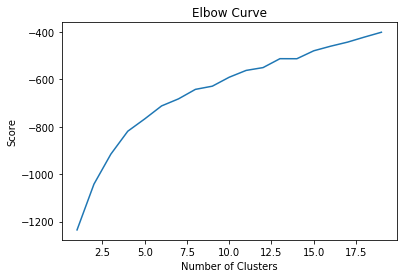

In [23]:
import pandas
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(testing_set).score(testing_set) for i in range(len(kmeans))]
score
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [24]:
pca = PCA(n_components=1).fit(testing_set)
pca_d = pca.transform(testing_set)
pca_c = pca.transform(testing_set)

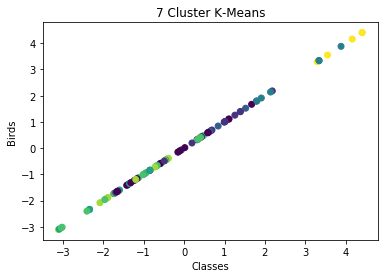

In [25]:

kmeans=KMeans(n_clusters=8)
kmeansoutput=kmeans.fit(testing_set)
kmeansoutput
pl.figure('7 Cluster K-Means')
pl.scatter(pca_c[:, 0], pca_d[:, 0], c=kmeansoutput.labels_)
pl.xlabel('Classes')
pl.ylabel('Birds')
pl.title('7 Cluster K-Means')
pl.show()


/home/rutherford/.local/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/rutherford/.local/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


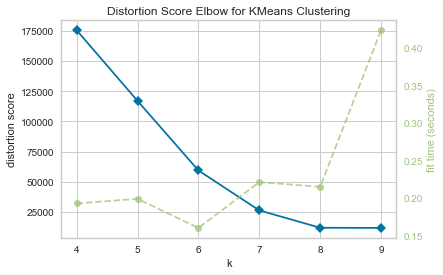

In [42]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
#X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
#testing_set, classes_num = X, y
# Instantiate the clustering model and visualizer
model = KMeans(testing_set)
visualizer = KElbowVisualizer(model, k=(4,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Affinity Propagation

In scikit-learn, other clustering algorithms such as affinity propagation can cluster without defining the number of clusters beforehand.

In [41]:
model_affinity = sklearn.cluster.AffinityPropagation()

In [42]:
model_affinity.fit(train_set, train_classes);

In [43]:
# Predict using the Test Set
predicted_labels = model_affinity.predict(test_set)
print(predicted_labels)

[1 2 2 6 5 5 9 2 7 7 6 7 2 2 5 7 2 2 2 3 3 5 2 2]
